## Drude Model

Recall that the electric susceptability of our material is modeled by
$$
\chi_j(t)=e^{-\gamma_jt}\left[A_{1,j}e^{\beta_jt}+A_{2,j}e^{-\beta_jt}\right]
$$
where $\beta=\sqrt{\gamma^2-\omega_0^2}$. To obtain the Drude model we choose the natural frequency $\omega_0=0$ and $A_{1,j}=-A_{2,j}$ for all $j$, which reduces $\chi_j(t)$ to
$$
\chi_j(t)=A_{1,j}\left[1-e^{-2\gamma_jt}\right]
$$
How do we transform this into frequency space?
which results in
$$
\sigma(\omega)=\frac{\omega_0}{1+i\omega t}
$$

We start by importing the needed libraries and defining our simulation bounds and constants. Our simulation will begin at time index $-1$ps and end at time index $1.5$ps. The simulations spatial bounds will span from $-5$um to $10$um.

In [1]:
%matplotlib inline
# Imports
from rcfdtd_sim import Simulation as Sim
from rcfdtd_sim import Material as Mat
from rcfdtd_sim import StaticMaterial as StaticMat
from rcfdtd_sim import Current, vis
import numpy as np
from scipy.fftpack import fft, fftfreq, fftshift
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from pathlib import Path
# Determine file save name
fsave = 'drude_model.npz'
# Constants
c0 = 3e8 # um/ps
di = 0.03e-6 # 0.03 um
dn = di/c0 # (0.03 um) / (3e8 m/s) = 0.1 fs
epsilon0 = 8.854187e-12
mu0 = np.divide(1, np.multiply(epsilon0, np.square(c0)))
# Define bounds
i0 = -1e-6 # -1 um
i1 = 1e-6 # 1 um
n0 = -0.5e-12 # -0.5 ps
n1 = 0.5e-12 # 0.5 ps
# Calculate dimensions and arrays to hold cell values
ilen, nlen = Sim.calc_dims(i0, i1, di, n0, n1, dn)
z, t = Sim.calc_arrays(i0, i1, di, n0, n1, dn)
print('nlen=%i, ilen=%i' % (nlen, ilen))

nlen=10000, ilen=68


## Setup Current

Specify the location of our current pulse in time and space

In [2]:
cp_loc_val = -0.5e-6 # -0.5 um
cp_time_val = 0 # 0 fs

Determine the simulation indicies that correspond to these locations

In [3]:
# Find indicies
cp_loc_ind = np.argmin(np.abs(np.subtract(z, cp_loc_val)))
cp_time_ind = np.argmin(np.abs(np.subtract(t, cp_time_val)))
# Find start and end indicies in time
spread = 3500
cp_time_s = cp_time_ind - spread
cp_time_e = cp_time_ind + spread

Create the current pulse

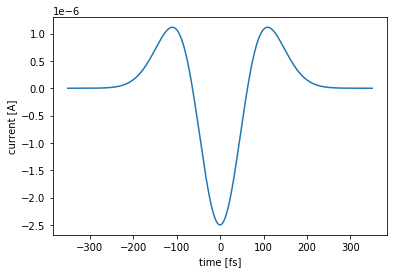

In [4]:
# Make pulse
cpulse = np.append(np.diff(np.diff(np.exp(-((t[cp_time_s:cp_time_e]-cp_time_val)**2)/(8e-27)))), [0,0])
# Plot
plt.plot(t[cp_time_s:cp_time_e]*1e15, cpulse)
plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('time [fs]')
plt.ylabel('current [A]')
plt.show()
# Create Current object
current = Current(cp_loc_ind, cp_time_s, ilen, nlen, cpulse)

## Setup Material

Specify the location of our material (which will be $12$nm in length)

In [5]:
# Set material length
m_len = 0.050e-6 # 50 nm
# Set locations
m_s_val = 0
m_e_val = m_s_val + m_len

Calculate the starting and ending indicies of our material

In [6]:
m_s_ind = np.argmin(np.abs(np.subtract(z, m_s_val)))
m_e_ind = np.argmin(np.abs(np.subtract(z, m_e_val)))

Setup material behavior

In [7]:
# Set constants
a1 = np.complex64(1e16)
gamma = np.complex64(1e12)
freq = np.complex64(0)
inf_perm = np.complex64(1e0)
# Calculate beta
ang_gamma = np.complex64(gamma * 2 * np.pi)
omega = np.complex64(freq * 2 * np.pi)
beta = np.sqrt(np.add(np.square(ang_gamma), -np.square(omega)), dtype=np.complex64)
a2 = -a1

Create our material behavior matrices

In [8]:
# Determine matrix length
mlen = m_e_ind - m_s_ind
# Create matrices
m = np.ones((1, mlen), dtype=np.complex64)
mgamma = m * ang_gamma
mbeta = m * beta
ma1 = m * a1
ma2 = m * a2

Create our material object

In [9]:
material = StaticMat(di, dn, ilen, nlen, m_s_ind, inf_perm, ma1, ma2, mgamma, mbeta, istore=[1])

## Running the Simulation

Create and run our simulation (or load simulation if one already exists)

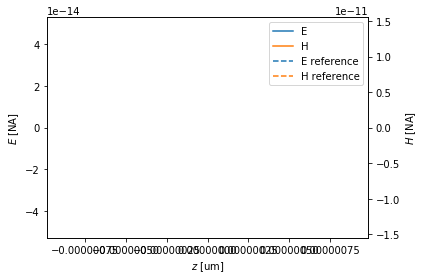

In [10]:
# Create Sim object
tqdmarg = {'desc': 'Executing simulation', 'leave': False}
s = Sim(i0, i1, di, n0, n1, dn, epsilon0, mu0, 'absorbing', current, material, nstore=np.arange(0, nlen, 50), istore=[5,ilen-6])
# Run simulation if simulation save doesn't exist
sim_file = Path(fsave)
if sim_file.is_file():
    # Load results
    dat = np.load(fsave)
    t = dat['t']
    els = dat['els']
    erls = dat['erls']
    hls = dat['hls']
    hrls = dat['hrls']
    chi = dat['chi']
else:
    # Run simulation
    s.simulate(tqdmarg)
    # Export visualization
    vis.timeseries(s, z, iunit='um')
    # Export and save arrays
    hls, els, hrls, erls = s.export_ifields()
    chi = material.export_ifields()
    np.savez(fsave, t=t, els=els, erls=erls, hls=hls, hrls=hrls, chi=chi)

Plot $\chi$

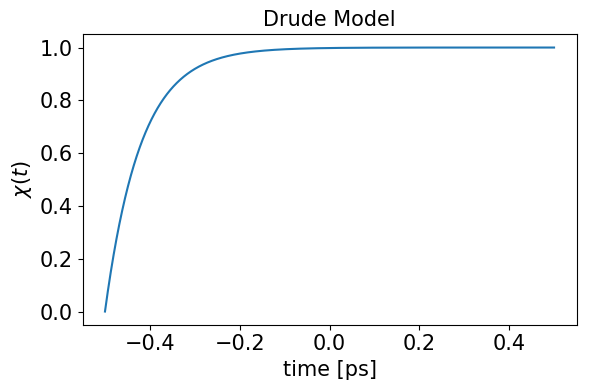

In [11]:
# Plot
fig, ax0 = plt.subplots(1, 1, sharex=True, dpi=100)
ax0.set_ylabel(r'$\chi(t)$', fontsize=15)
ax0.set_xlabel(r'time [ps]', fontsize=15)
ax0.set_title(r'Drude Model', fontsize=15)
ax0.ticklabel_format(style='sci', scilimits=(0,0), axis='y', fontsize=15)
ax0.tick_params(labelsize=15)

ax0.plot(t*1e12, np.real(chi))

plt.tight_layout()

plt.savefig('drude_model_chi.pdf', format='pdf')
plt.show()

Plot fields in time

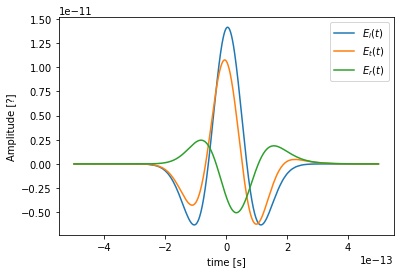

In [12]:
# Extract incident, transmitted, and reflected fields
inc = erls[:,1]
trans = els[:,1]
refl = els[:,0] - erls[:,0]

# Plot
plt.plot(t, np.real(inc), label='$E_i(t)$')
plt.plot(t, np.real(trans), label='$E_t(t)$')
plt.plot(t, np.real(refl), label='$E_r(t)$')
plt.ylabel('Amplitude [?]')
plt.xlabel('time [s]')
plt.legend()
plt.show()

Transform time-domain fields into frequency domain fields and plot.

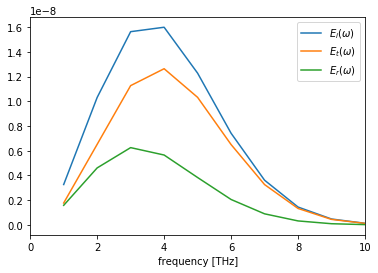

In [13]:
# Calculate time difference
dt = np.diff(t)[0] # Calculate time step difference in fs

# Calculate Fourier transforms
freq = fftfreq(nlen, dt) # in THz (since [dt]=[fs], 1/[dt] = 1/[fs] = 10^15/[s] = 10^3*10^12/[s] = 10^4*[THz])
incf = fft(inc)
transf = fft(trans)
reflf = fft(refl)

# Removeunwanted frequencies
freq = freq[1:int(nlen/2)]
incf = incf[1:int(nlen/2)]
transf = transf[1:int(nlen/2)]
reflf = reflf[1:int(nlen/2)]

# Plot transformed fields
plt.plot(freq * 1e-12, np.abs(incf), label='$E_i(\omega)$')
plt.plot(freq * 1e-12, np.abs(transf), label='$E_t(\omega)$')
plt.plot(freq * 1e-12, np.abs(reflf), label='$E_r(\omega)$')
plt.xlabel(r'frequency [THz]')
plt.xlim(0, 10)
plt.legend()
plt.show()

Extract transmission coefficient $\tilde T=A(\omega)+i\phi(\omega)$ into `spec_m` and `spec_a` arrays representing $A(\omega)$ and $\phi(\omega)$, respectively. To prevent a `divide by zero` error we remove the indicies at which the incident field $E_i(\omega)$ is zero.

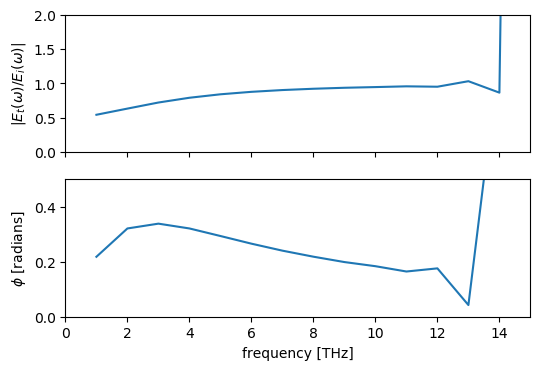

In [14]:
# Remove zero indicies from all arrays
nonzero_ind = np.nonzero(incf)
freq = freq[nonzero_ind]
incf = incf[nonzero_ind]
transf = transf[nonzero_ind]
reflf = reflf[nonzero_ind]

# Calculate spectrum in frequency
spec = np.divide(transf, incf)

# Remove zero indicies from all arrays
nonzero_ind = np.nonzero(spec)
freq = freq[nonzero_ind]
incf = incf[nonzero_ind]
transf = transf[nonzero_ind]
spec = spec[nonzero_ind]

# Extract phase and magnitude
spec_m = np.absolute(spec)
spec_a = np.abs(np.unwrap(np.angle(spec)))

# Plot
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, dpi=100)
ax0.plot(freq * 1e-12, spec_m)
ax1.plot(freq * 1e-12, spec_a)
ax1.set_xlim(0, 15)
ax0.set_ylim(0, 2)
ax1.set_ylim(0, 0.5)
ax0.set_ylabel(r'$\left|E_t(\omega)/E_i(\omega)\right|$')
ax1.set_ylabel(r'$\phi$ [radians]')
ax1.set_xlabel(r'frequency [THz]')
plt.show()

We wish to calculate the index of refraction
$$\tilde{n}(\omega)=n(\omega)+i\kappa(\omega)$$
where $\kappa\ll n$. From Benjamin Ofori-Okai's 2016 PhD thesis Eq.(5.41) we note that conductivity is defined as
$$
\tilde{\sigma}(\omega)=\frac{2}{Z_0d}\left(\frac{1}{\tilde{t}(\omega)}-1\right)
$$
for a sample in vacuum where $Z_0$ is the impedance of free space, $d$ is the sample width, and $\tilde{t}(\omega)=\frac{E_t(\omega)}{E_i(\omega)}$. The index of refraction $\tilde{n}(\omega)$ is related to the conductivity $\tilde{\sigma}(\omega)$ via
$$
\tilde{n}(\omega)=\sqrt{\epsilon_\infty+\frac{i\tilde{\sigma}(\omega)}{\omega\epsilon_0}}
$$

This calculation is valid in the limit $\kappa\gg n$, or the _thin sample limit_. This simulation operates in this regime.

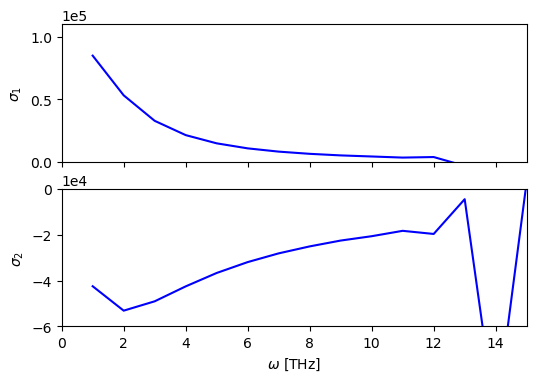

In [15]:
# Set constants
Z0 = np.multiply(mu0, c0) # Ohms (impedance of free space)

# Calculate the angular frequency
ang_freq = 2 * np.pi * freq # THz * 2pi

# Calculate conductivity
conductivity = np.multiply(np.divide(2, Z0*m_len), np.subtract(np.divide(1, spec), 1))

# Calculate index of refraction
#n_complex = np.sqrt(inf_perm + np.divide(np.multiply(1j, conductivity), np.multiply(ang_freq, epsilon0)))

# Calculate the imaginary part of the index of refraction
#n1 = np.real(n_complex)
#kappa1 = np.imag(n_complex)

# Setup plot
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, dpi=100)
ax0.set_ylabel(r'$\sigma_1$')
ax1.set_ylabel(r'$\sigma_2$')
ax1.set_xlabel(r'$\omega$ [THz]')
ax1.set_xlim(0, 15)
ax0.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax0.set_ylim(0, 1.1e5)
ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax1.set_ylim(-6e4, 0)

# Plot conductivity
ax0.plot(freq * 1e-12, np.real(conductivity), 'b-')
ax1.plot(freq * 1e-12, np.imag(conductivity), 'b-')

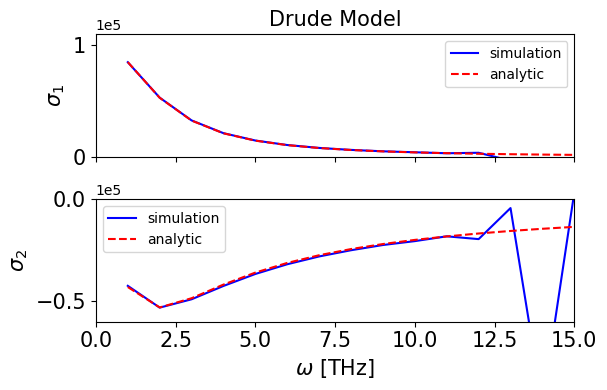

In [16]:
# Find max frequency
freq_max = np.argmin(np.abs(np.subtract(14e12, freq)))

# Define fit functions
def cond_real(omega, sigma0, tau):
    return sigma0/(1+(tau*omega)**2)

def cond_imag(omega, sigma0, tau):
    return (-omega*tau*sigma0)/(1+(tau*omega)**2)

# Take real and imaginary parts
cfreq = freq[:freq_max]
creal = np.real(conductivity)[:freq_max]
cimag = np.imag(conductivity)[:freq_max]

# Run curve fit
popt_real, pcov_real = curve_fit(cond_real, cfreq, creal, p0=[1e5, 0.4e-12])
popt_imag, pcov_imag = curve_fit(cond_imag, cfreq, cimag, p0=[1e5, 0.2e-12])

fit_real = cond_real(freq, *popt_real)
fit_imag = cond_imag(freq, *popt_imag)

# Setup plot
fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, dpi=100)
ax0.set_ylabel(r'$\sigma_1$', fontsize=15)
ax1.set_ylabel(r'$\sigma_2$', fontsize=15)
ax1.set_xlabel(r'$\omega$ [THz]', fontsize=15)
ax0.set_title(r'Drude Model', fontsize=15)
ax1.set_xlim(0, 15)
ax0.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax0.tick_params(labelsize=15)
ax0.set_ylim(0, 1.1e5)
ax1.ticklabel_format(style='sci', scilimits=(0,0), axis='y')
ax1.tick_params(labelsize=15)
ax1.set_ylim(-6e4, 0)

# Plot simulated conductivity
ax0.plot(freq*1e-12, np.real(conductivity), 'b-', label='simulation')
ax1.plot(freq*1e-12, np.imag(conductivity), 'b-', label='simulation')

# Plot analytic conductivity
ax0.plot(freq*1e-12, fit_real, 'r--', label='analytic')
ax1.plot(freq*1e-12, fit_imag, 'r--', label='analytic')

ax0.legend()
ax1.legend()

plt.tight_layout()

plt.savefig('drude_model.pdf', format='pdf')
plt.show()